In [1]:
# Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

In [4]:
# Data Reading

df = pd.read_excel("../data/Registro Público de Emissões.xlsx")

In [ ]:
# Data Processing

df = df[df["Escopo"] == "Total"]
df.reset_index(inplace=True)
df.drop(columns=["index", "Setor da Indústria", "Escopo"], inplace=True)

X_train_str = df.columns[-7:].values
X_train = X_train_str.astype(int)

list_of_companies = df.Empresa.values

# df.iloc[:, 1:] /= 1e7

display(df.head())

,Empresa,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Suzano,1071559.17,734909.56,1050928.8,1369237.85,1355714.11,1287628.03,1766173.27,2195385.65,1408928.09,1336754.86,1269096.85,3510477.86,3777425.13,4280282.87,4048948.87,4085794.51
1,Companhia Siderúrgica Nacional (CSN),NaN,NaN,NaN,NaN,NaN,201073.40,398435.90,358696.39,696166.54,15521114.32,15044354.64,11179903.99,51838553.42,56986963.83,62768571.05,68983109.92
2,Intercement,NaN,NaN,NaN,NaN,NaN,1796332.91,1878122.78,1662365.83,1284986.73,1285356.44,1211968.29,1255259.84,1399664.56,1568611.67,1602633.88,1576466.04
3,Ternium Brasil,NaN,NaN,NaN,NaN,NaN,9399928.51,10177952.92,11090420.64,11209372.11,12076763.89,11429445.82,11082661.39,10371065.91,11691472.75,11319741.92,12759252.85
4,Votorantim,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17003897.97,14107418.23,13086996.77,13637983.13,12469542.86,13387612.89,17197925.07,15552532.45,14949003.45


In [ ]:
# Auxiliaries Function


def filters_a_company(df, company_name):
    df = df[df.Empresa == company_name]
    df = df.drop(columns=["Empresa"])
    return df


def extracts_commum_values(df, column_names):
    df = df[column_names]
    return df.values[0]


def extracts_specific_values(df):
    df = df.dropna(axis=1)
    X = df.columns
    X = X.astype(int)
    y = df.values[0]
    return X, y


def applies_linear_regression(X, y, X_pred):
    model = LinearRegression()
    model.fit(X.reshape(-1, 1), y)
    y_pred = model.predict(X_pred.reshape(-1, 1))

    print(f"The score is {model.score(X.reshape(-1, 1), y)}.")
    return y_pred


def applies_autoregressive_model(data, p=0, d=0, q=0, steps_for_forec=1):
    model = ARIMA(data, order=(p, d, q)).fit()
    y_pred = model.forecast(steps=steps_for_forec)
    return y_pred


def generate_plot(company_name, X, y, X_pred, y_pred):
    (line,) = plt.plot(X, y, label=company_name)
    plt.plot(X_pred, y_pred, "o", color=line.get_color())


Suzano
The score is 0.7366724666624691.

Companhia Siderúrgica Nacional (CSN)
The score is 0.8464670054768695.

Intercement
The score is 0.8201733045549879.

Ternium Brasil
The score is 0.06176732570905141.

Votorantim
The score is 0.4336155635392488.

ArcelorMittal
The score is 0.5297258399638223.

Companhia Brasileira de Alumínio (CBA)
The score is 0.47974353668039516.

ISA Energia Brasil
The score is 0.2047012438450726.


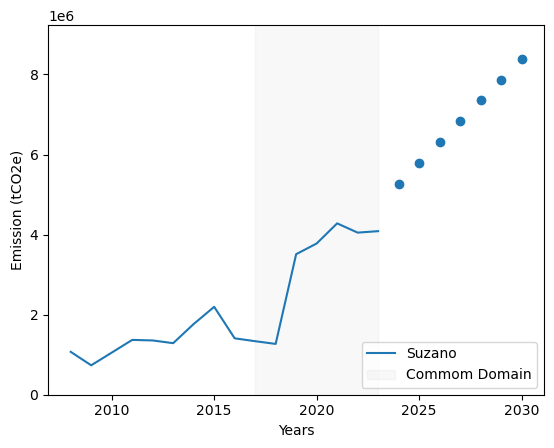

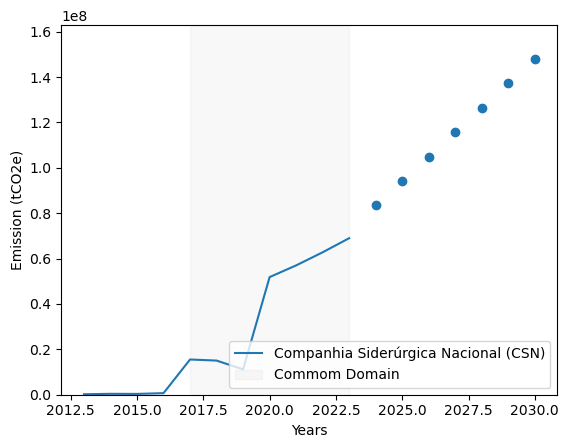

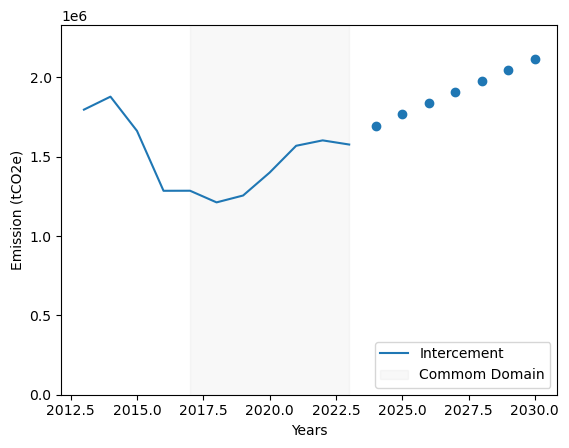

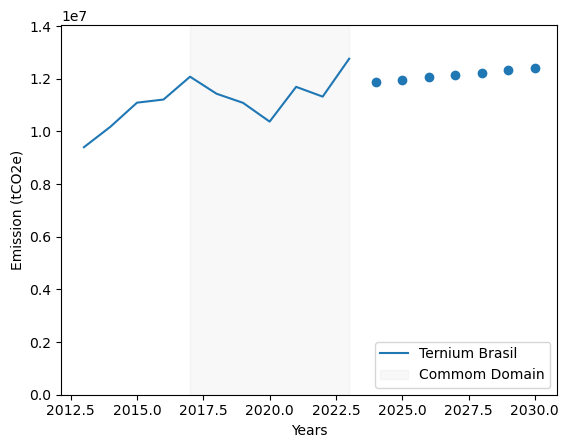

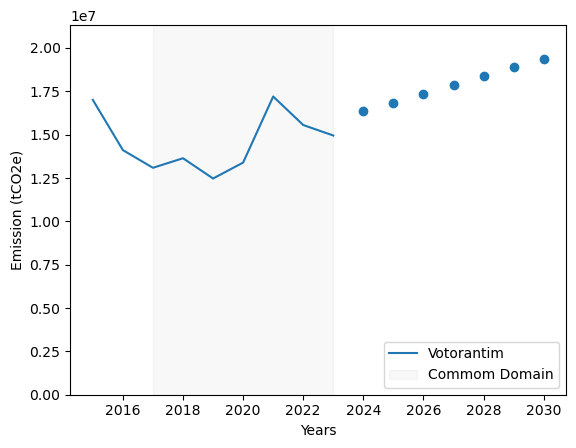

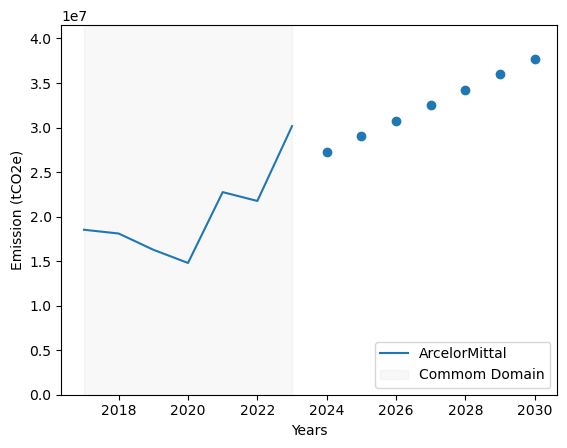

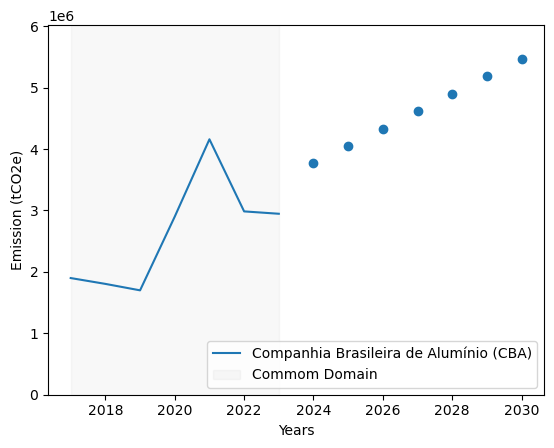

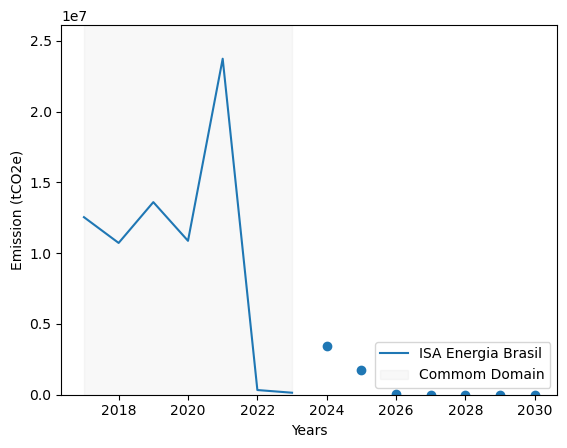

In [ ]:
# Main

X_pred = np.array(range(2024, 2031))

# ARIMA Model
if False:

    for company_name in list_of_companies:
        p, d, q = 6, 0, 3

        df_company = filters_a_company(df, company_name)
        y_train = extracts_commum_values(df_company, X_train_str)
        X_plot, y_plot = extracts_specific_values(df_company)
        y_pred = applies_autoregressive_model(
            y_train, p=p, d=d, q=q, steps_for_forec=len(X_pred)
        )

        plt.figure()
        generate_plot(company_name, X_plot, y_plot, X_pred, y_pred)
        plt.ylim([0, 1.1 * max(y_plot)])
        plt.axvspan(
            min(X_train), max(X_train), color="gray", alpha=0.05, label="Commom Domain"
        )
        plt.legend(loc="lower right")
        plt.xlabel("Years")
        plt.ylabel("Emission (tCO2e)")
        # plt.savefig(f"../img/ARIMA(p={p}, d={d}, q={q}) - {company_name}", transparent=True, dpi=300)

# Linear Model
if True:

    for company_name in list_of_companies:
        print(f"\n{company_name}")
        df_company = filters_a_company(df, company_name)
        y_train = extracts_commum_values(df_company, X_train_str)
        X_plot, y_plot = extracts_specific_values(df_company)

        y_pred = applies_linear_regression(X_train, y_train, X_pred)

        y_pred[y_pred < 0] = 0

        plt.figure()
        generate_plot(company_name, X_plot, y_plot, X_pred, y_pred)
        plt.ylim([0, 1.1 * max(max(y_plot), max(y_pred))])
        plt.axvspan(
            min(X_train), max(X_train), color="gray", alpha=0.05, label="Commom Domain"
        )
        plt.legend(loc="lower right")
        plt.xlabel("Years")
        plt.ylabel("Emission (tCO2e)")
        plt.savefig(f"../img/Linear Model - {company_name}", transparent=True, dpi=300)

In [72]:
df_rolling = df.transpose()
df_rolling.columns = df_rolling.iloc[0]
df_rolling = df_rolling[1:].reset_index()
df_rolling = df_rolling.rename(columns={"index": "Years"})
df_rolling = df_rolling[df_rolling.Years >= 2017]
df_rolling = df_rolling.drop("Years", axis=1)
new_df = df_rolling.rolling(window=3).mean()
display(df_rolling)
display(new_df)

Empresa,Suzano,Companhia Siderúrgica Nacional (CSN),Intercement,Ternium Brasil,Votorantim,ArcelorMittal,Companhia Brasileira de Alumínio (CBA),ISA Energia Brasil
9,1336754.86,15521114.32,1285356.44,12076763.89,13086996.77,18522944.39,1899397.45,12538927.8
10,1269096.85,15044354.64,1211968.29,11429445.82,13637983.13,18100720.35,1804299.79,10718949.94
11,3510477.86,11179903.99,1255259.84,11082661.39,12469542.86,16277690.41,1699306.44,13600628.68
12,3777425.13,51838553.42,1399664.56,10371065.91,13387612.89,14791856.84,2899654.11,10868626.07
13,4280282.87,56986963.83,1568611.67,11691472.75,17197925.07,22748055.45,4158522.18,23728704.1
14,4048948.87,62768571.05,1602633.88,11319741.92,15552532.45,21754861.87,2984518.11,330664.96
15,4085794.51,68983109.92,1576466.04,12759252.85,14949003.45,30159528.37,2946017.47,141590.84


Empresa,Suzano,Companhia Siderúrgica Nacional (CSN),Intercement,Ternium Brasil,Votorantim,ArcelorMittal,Companhia Brasileira de Alumínio (CBA),ISA Energia Brasil
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.038777e+06,1.391512e+07,1.250862e+06,1.152962e+07,1.306484e+07,1.763379e+07,1.801001e+06,1.228617e+07
12,2.852333e+06,2.602094e+07,1.288964e+06,1.096106e+07,1.316505e+07,1.639009e+07,2.134420e+06,1.172940e+07
13,3.856062e+06,4.000181e+07,1.407845e+06,1.104840e+07,1.435169e+07,1.793920e+07,2.919161e+06,1.606599e+07
14,4.035552e+06,5.719803e+07,1.523637e+06,1.112743e+07,1.537936e+07,1.976492e+07,3.347565e+06,1.164267e+07
15,4.138342e+06,6.291288e+07,1.582571e+06,1.192349e+07,1.589982e+07,2.488748e+07,3.363019e+06,8.066987e+06
